In [5]:
import requests  
import time
import pandas as pd
from itertools import product
from mip import Model, xsum, minimize, BINARY
from geopy import distance
import plotly
import plotly.express as px
import plotly.graph_objects as go

## Load data from CSV-File
However, there are some very small independently governed areas/countries in Europe (= population lower than 300.000 inhabitants). Those countries are removed for our optimization problem to reduce the complexity.

In [6]:
df = pd.read_csv('EU_capitals.csv')
df = df[df.population > 300000]
df.reset_index(inplace=True, drop=True)
df.head()

,country,capital,lat,long,code,population
0,Albania,Tirana,41.315886,19.900912,AL,2886026
1,Austria,Vienna,48.208354,16.372504,AT,8725931
2,Belarus,Minsk,53.902334,27.561879,BY,9498700
3,Belgium,Brussels,50.846557,4.351697,BE,11319511
4,Bosnia and Herzegovina,Sarajevo,43.851977,18.386687,BA,3531159


## Choose Start and End point:

In [7]:
start = 'Iceland'
end = 'Cyprus'

Rearrange the Dataframe to start with the selected Start point:

In [8]:
id_start = df.index[df['country'] == start][0]
df = df.take([id_start]).append(df.drop(df.index[id_start]))
df = df.reset_index(drop=True)
id_end = df.index[df['country'] == end][0]

## Calculate Distance Matrix
In the next step, I calculated the distance matrix for all capitals:

In [9]:
dist = [[distance.distance((df.lat[i],df.long[i]),(df.lat[j],df.long[j])).km for j in range(len(df))] for i in range(len(df))]

## Define model and contraints
1. X represents a matrix of zeros and ones, which indicates if a vertix between two nodes/capitals (i,j) exists (=1) or not (=0)
2. Y represents a list of numbers, which indicate the 'traveling'-sequence of the nodes/capitals.

objective: the 'traveling'-route should have a minimized distance

contraints: 
- each node should only be entered once (except starting node is entered zero times)
- each node should only be left once (except end point is left zero times)
- it should be one route and no subroutes

In [10]:
# number of nodes and list of vertices
n = len(dist) 
V = set(range(len(dist)))

model = Model()

# binary variables indicating if arc (i,j) is used on the route or not
x = [[model.add_var(var_type=BINARY) for j in V] for i in V]

# continuous variable to prevent subtours: each city will have a
# different sequential id in the planned route except the first one
y = [model.add_var() for i in V]

# objective function: minimize the distance
model.objective = minimize(xsum(dist[i][j]*x[i][j] for i in V for j in V))

# constraint : leave each city only once
for i in V-{id_end}:
    model += xsum(x[i][j] for j in V - {i}) == 1

# constraint : enter each city only once
for i in V-{0}:
    model += xsum(x[j][i] for j in V - {i}) == 1

# subtour elimination
for (i, j) in product(V - {0}, V - {0}):
    if i != j:
        model += y[i] - (n+1)*x[i][j] >= y[j]-n

# optimizing
model.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [12]:
if model.num_solutions:
        order = []
        nc = 0
        order.append(nc)
        while True:
            nc = [i for i in V if x[nc][i].x >= 0.99][0]
            order.append(nc)
            if nc == id_end:
                break
df.loc[order]

,country,capital,lat,long,code,population
0,Iceland,Reykjavík,64.145981,-21.942237,IS,334300
17,Ireland,Dublin,53.349764,-6.260273,IE,6378000
29,Portugal,Lisbon,38.707751,-9.136592,PT,10374822
36,Spain,Madrid,40.416705,-3.703582,ES,46438422
13,France,Paris,48.856697,2.351462,FR,66710000
40,United Kingdom of Great Britain and Northern I...,London,51.507322,-0.127647,GB,65110000
26,Netherlands,Amsterdam,52.372760,4.893604,NL,17019800
4,Belgium,Brussels,50.846557,4.351697,BE,11319511
21,Luxembourg,Luxembourg,49.611277,6.129799,LU,576200
38,Switzerland,Bern,46.948271,7.451451,CH,8341600


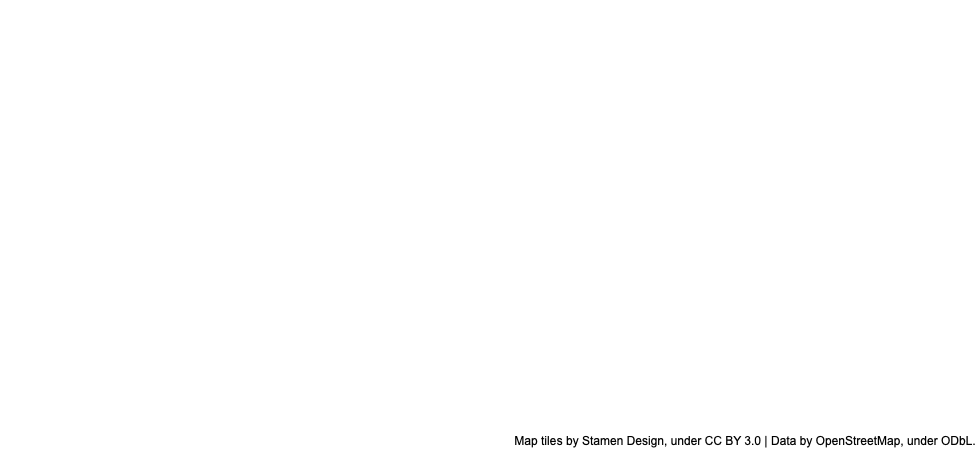

In [15]:
fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    text = df.loc[order].capital,
    lon = df.loc[order].long,
    lat = df.loc[order].lat,
    marker = {'size': 10}))

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': df['long'].mean(), 'lat': df['lat'].mean()},
        'style': "stamen-terrain",
        'zoom': 2.3})